In [29]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import sys
import dlib
import numpy

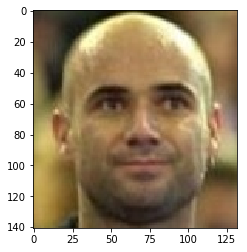

In [30]:
facePath = "Andre_Agassi_0010.jpg"
profilePath = "Aaron_Pena_0001.jpg"
fullImg = cv2.cvtColor(cv2.imread(facePath), cv2.COLOR_BGR2RGB)
profileFullImg = cv2.cvtColor(cv2.imread(profilePath), cv2.COLOR_BGR2RGB)
plt.imshow(fullImg)

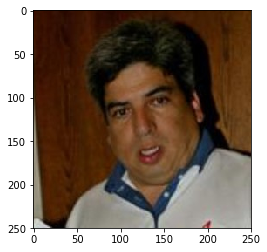

In [31]:
plt.imshow(profileFullImg)

In [32]:
detector = dlib.get_frontal_face_detector()
profileDetector = dlib.get_frontal_face_detector()
dets = detector(fullImg, 1)
profileDets = profileDetector(profileFullImg, 1)
print "face number is {0} & {1}".format(len(dets), len(profileDets))
detect = dets[0]
print "Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(0, detect.left(), detect.top(), detect.right(), detect.bottom())
profileDetect = profileDets[0]
print "& Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(0, profileDetect.left(), profileDetect.top(),
                                                                     profileDetect.right(), profileDetect.bottom())

face number is 1 & 1
Detection 0: Left: 25 Top: 35 Right: 114 Bottom: 125
& Detection 0: Left: 78 Top: 78 Right: 185 Bottom: 186


In [33]:
shapePredict = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

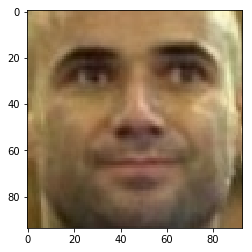

In [34]:
margin = 2
faceImg = fullImg[detect.top() - margin:detect.bottom() + margin,detect.left() - margin:detect.right() + margin,:]
plt.imshow(faceImg)

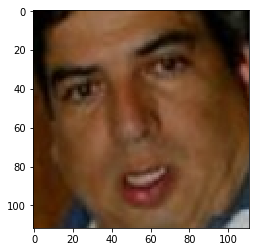

In [35]:
profileImg = profileFullImg[profileDetect.top() - margin:profileDetect.bottom() + margin,
                            profileDetect.left() - margin:profileDetect.right() + margin,:]
plt.imshow(profileImg)

In [36]:
shape = shapePredict(fullImg, detect)
print "Total parts of {}.".format(shape.num_parts)
profileShape = shapePredict(profileFullImg, profileDetect)
print "&Total parts of {}.".format(shape.num_parts)

Total parts of 68.
&Total parts of 68.


In [37]:
xMin = len(fullImg[0])
xMax = 0
yMin = len(fullImg)
yMax = 0
for i in range(shape.num_parts):
    if (shape.part(i).x < xMin):
        xMin = shape.part(i).x
    if (shape.part(i).x > xMax):
        xMax = shape.part(i).x
    if (shape.part(i).y < yMin):
        yMin = shape.part(i).y
    if (shape.part(i).y > yMax):
        yMax = shape.part(i).y
print "x min is {}, x max is {}, y min is {}, y max is {}".format(xMin, xMax, yMin, yMax)

x min is 23, x max is 113, y min is 47, y max is 129


In [38]:
pxMin = len(profileFullImg[0])
pxMax = 0
pyMin = len(profileFullImg)
pyMax = 0
for i in range(profileShape.num_parts):
    if (profileShape.part(i).x < pxMin):
        pxMin = profileShape.part(i).x
    if (profileShape.part(i).x > pxMax):
        pxMax = profileShape.part(i).x
    if (profileShape.part(i).y < pyMin):
        pyMin = profileShape.part(i).y
    if (profileShape.part(i).y > pyMax):
        pyMax = profileShape.part(i).y
print "x min is {}, x max is {}, y min is {}, y max is {}".format(pxMin, pxMax, pyMin, pyMax)

x min is 81, x max is 188, y min is 88, y max is 200


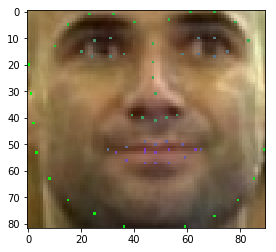

In [39]:
newImage = fullImg
for i in range(len(fullImg)):
    for j in range(len(fullImg[0])):
        found = False
        for k in range(shape.num_parts):
            if (shape.part(k).x == j and shape.part(k).y == i):
                newImage[i,j] = [k*2,255-k*3,k*3]
                break
plt.imshow(newImage[yMin:yMax,xMin:xMax,:])

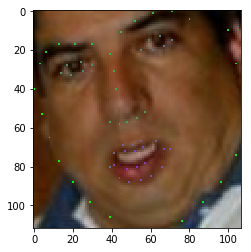

In [40]:
newProfileImage = profileFullImg
for i in range(len(profileFullImg)):
    for j in range(len(profileFullImg[0])):
        found = False
        for k in range(profileShape.num_parts):
            if (profileShape.part(k).x == j and profileShape.part(k).y == i):
                newProfileImage[i,j] = [k*2,255-k*3,k*3]
                break
plt.imshow(newProfileImage[pyMin:pyMax,pxMin:pxMax,:])

In [41]:
controlSrcPts = numpy.zeros((profileShape.num_parts,2))
controlDstPts = numpy.zeros((shape.num_parts,2))

if shape.num_parts != profileShape.num_parts:
    print "number not equal!"
for i in range(profileShape.num_parts):
    if (profileShape.part(i).x < 0):
        print i + "th part x < 0"
    if (profileShape.part(i).y < 0):
        print i + "th part y < 0"
    controlSrcPts[i] = [profileShape.part(i).x - pxMin, profileShape.part(i).y - pyMin]
for i in range(shape.num_parts):
    if (shape.part(i).x < 0):
        print i + "th part x < 0"
    if (shape.part(i).y < 0):
        print i + "th part y < 0"
    controlDstPts[i] = [shape.part(i).x - xMin, shape.part(i).y - yMin]

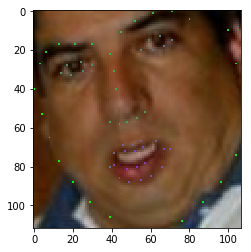

In [42]:
cropPFace = newProfileImage[pyMin:pyMax,pxMin:pxMax,:]
plt.imshow(cropPFace)

In [43]:
import MovingLSQ as MLSQ
solver = MLSQ.MovingLSQ(controlSrcPts, controlDstPts)
imgIdx = numpy.zeros((len(cropPFace)*len(cropPFace[0]),2))

# 先列出原图坐标，再计算每一个像素变换后的坐标
for i in range(len(cropPFace)):
    for j in range(len(cropPFace[0])):
        imgIdx[i*len(cropPFace[0]) + j] = [j, i]    #图片的x坐标对应的是列即j值，y坐标对应的是行即i值
imgMls = solver.Run_Rigid(imgIdx)

`ftol` termination condition is satisfied.
Function evaluations 252, initial cost 2.4853e+03, final cost 1.4924e+03, first-order optimality 5.21e-02.


In [44]:
mlsMargin = [0, 0, len(cropPFace[0]), len(cropPFace)]
for i in range(len(imgMls)):
    if (imgMls[i][0] < mlsMargin[0]):
        mlsMargin[0] = imgMls[i][0]
    if (imgMls[i][1] < mlsMargin[1]):
        mlsMargin[1] = imgMls[i][1]
    if (imgMls[i][0] > mlsMargin[2]):
        mlsMargin[2] = imgMls[i][0]
    if (imgMls[i][1] > mlsMargin[3]):
        mlsMargin[3] = imgMls[i][1]
# 变换后的坐标可能超出原图片大小，需要计算出血值
mlsMargin[2] -= len(cropPFace[0])
mlsMargin[3] -= len(cropPFace)
print mlsMargin

[-11.870329454276547, -20.57614066638923, 1.8394019876514847, 0]


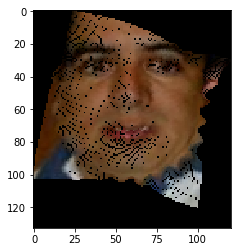

In [45]:
import math
imgMlsMap = imgMls.reshape((len(cropPFace), len(cropPFace[0]), 2))
leftMargin = -math.floor(mlsMargin[0])
topMargin = -math.floor(mlsMargin[1])
rightMargin = math.ceil(mlsMargin[2])
bottomMargin = math.ceil(mlsMargin[3])
deformedImage = numpy.zeros((len(cropPFace) + int(topMargin) + int(bottomMargin), 
                             len(cropPFace[0]) + int(leftMargin) + int(rightMargin), 3))
mask = numpy.zeros((deformedImage.shape[0], deformedImage.shape[1]))
profileFullImg = cv2.cvtColor(cv2.imread(profilePath), cv2.COLOR_BGR2RGB)
cropImg = profileFullImg[pyMin:pyMax,pxMin:pxMax,:]
for i in range(len(cropImg)):
    for j in range(len(cropImg[0])):
        x = int(math.floor(imgMlsMap[i][j][0]) + leftMargin)
        y = int(math.floor(imgMlsMap[i][j][1]) + topMargin)
        if (x < 0 or y < 0):
            print "i = {}, j = {}, x = {}, y = {}".format(i, j, x, y)
            break
        deformedImage[y, x] = cropImg[i, j]
        mask[y, x] = 1
plt.imshow(deformedImage.astype('uint8'))

In [46]:
len(newProfileImage[0]) + int(leftMargin) + int(rightMargin)

264

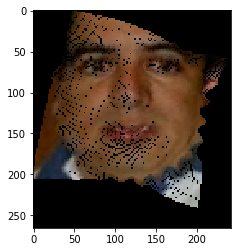

In [62]:
# 扩大一倍
FaceX2 = numpy.zeros((deformedImage.shape[0]*2, deformedImage.shape[1]*2, deformedImage.shape[2]))
for i in range(len(FaceX2)):
    for j in range(len(FaceX2[0])):
        FaceX2[i][j] = deformedImage[i/2][j/2]
plt.imshow(FaceX2.astype('uint8'))

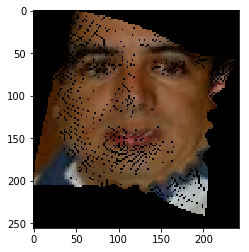

In [63]:
FaceX2 = FaceX2[:256,:,:]
plt.imshow(FaceX2.astype('uint8'))

In [64]:
FaceX2.shape

(256L, 242L, 3L)

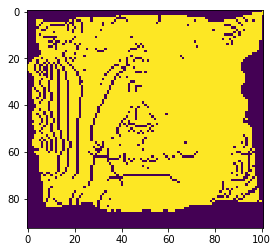

In [21]:
plt.imshow(mask)

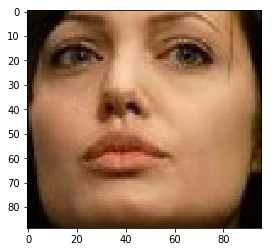

In [22]:
plt.imshow(cropImg)

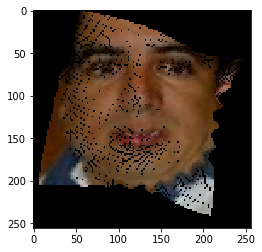

In [65]:
fullSize = 256
fullsizeImg = numpy.zeros((fullSize, fullSize, 3))
left = (fullSize - FaceX2.shape[1])/2
top = (fullSize - FaceX2.shape[0])/2
fullsizeImg[top:FaceX2.shape[0]-top, left:FaceX2.shape[1]+left, :] = FaceX2
plt.imshow(fullsizeImg.astype('uint8'))

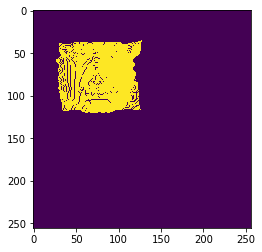

In [24]:
fullMask = numpy.zeros((fullSize, fullSize))
fullMask[top:deformedImage.shape[0]+top, left:deformedImage.shape[1]+left] = mask
plt.imshow(fullMask)

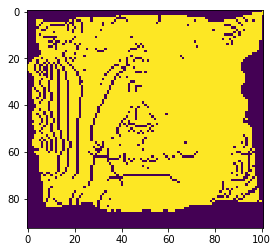

In [25]:
plt.imshow(mask)

In [26]:
from PIL import Image
im = Image.fromarray(fullsizeImg.astype('uint8'))
im.save(profilePath + "_front.jpg")
numpy.save(profilePath + "_mask.npy", fullMask)

In [27]:
bb = numpy.load(profilePath + "_mask.npy")

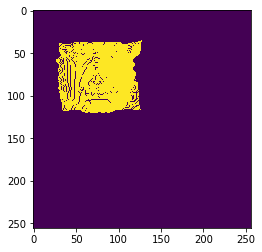

In [28]:
plt.imshow(bb)